# 第4章 聚类分析及其在客户细分中的应用

### 概要

- [根据相似度用k-means进行类别划分](#根据相似度用k-means进行类别划分)
  - [scikit-learn的K-means聚类](#scikit-learn的K-means聚类)
  - [使用elbow方法确定最优聚类数](#使用elbow方法确定最优聚类数)
  - [应用silhouette图来比较聚类质量](#应用silhouette图来比较聚类质量)
- [使用层次树进行聚类](#使用层次树进行聚类)
  - [自下而上的层次聚类](#自下而上的层次聚类)
  - [根据距离矩阵进行层次聚类](#根据距离矩阵进行层次聚类)
  - [通过scikit-learn进行凝聚聚类](#通过scikit-learn进行凝聚聚类)
- [通过DBSCAN划分高密度区域](#通过DBSCAN划分高密度区域)
- [聚类分析在客户细分中的应用](#聚类分析在客户细分中的应用)

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image

from sklearn.datasets import make_blobs
from sklearn.datasets import make_moons
from sklearn.metrics import silhouette_samples
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering

from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram


%matplotlib inline
# %matplotlib qt5
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号

# 根据相似度用k-means进行类别划分

## scikit-learn的K-means聚类

In [38]:
X, y = make_blobs(n_samples=150, 
                  n_features=2, 
                  centers=3, 
                  cluster_std=0.5, 
                  shuffle=True, 
                  random_state=0)

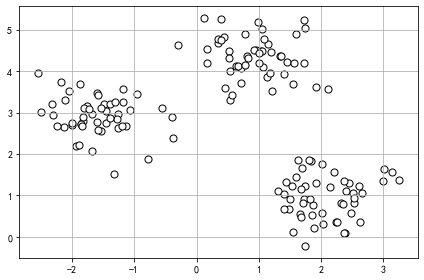

In [39]:
plt.scatter(X[:, 0], X[:, 1], 
            c='white', marker='o', edgecolor='black', s=50)
plt.grid()
plt.tight_layout()
#plt.savefig('images/11_01.png', dpi=300)
plt.show()

In [40]:
km = KMeans(n_clusters=3, 
            init='random', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)

In [41]:
y_km = km.fit_predict(X)             #将fit和predict合并，先用X训练模型，再计算根据X的预测结果

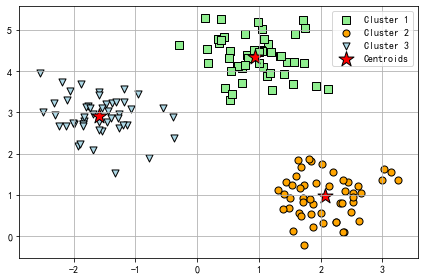

In [42]:
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50, c='lightgreen',
            marker='s', edgecolor='black',
            label='Cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50, c='orange',
            marker='o', edgecolor='black',
            label='Cluster 2')
plt.scatter(X[y_km == 2, 0],
            X[y_km == 2, 1],
            s=50, c='lightblue',
            marker='v', edgecolor='black',
            label='Cluster 3')
plt.scatter(km.cluster_centers_[:, 0], #质心的横坐标
            km.cluster_centers_[:, 1], #质心的纵坐标
            s=250, marker='*',
            c='red', edgecolor='black',
            label='Centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
#plt.savefig('images/11_02.png', dpi=300)
plt.show()

## 使用elbow方法确定最优聚类数

In [43]:
print('Distortion: %.2f' % km.inertia_)

Distortion: 72.48


C:\Users\ThinkPad\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1039: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "


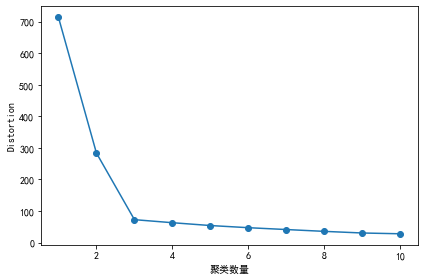

In [44]:
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, 
                init='k-means++', 
                n_init=10, 
                max_iter=300, 
                random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('聚类数量')
plt.ylabel('Distortion')
plt.tight_layout()
#plt.savefig('images/4.0clustering.png', dpi=300)
plt.show()

在$k=3$处有一个弯头，这意味着少于该值的集群将是不好的，而更多的集群将不会有多大帮助.

<br>

## 应用silhouette图来比较聚类质量

In [45]:
km = KMeans(n_clusters=3, 
            init='k-means++', 
            n_init=10, 
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

## 计算每个样本的Silhouette系数

In [46]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean') 

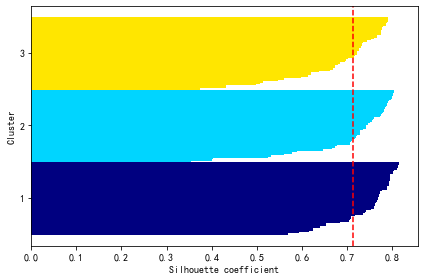

In [47]:
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    

    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('images/11_04.png', dpi=300)
plt.show()

比较不好的聚类结果:

In [48]:
km = KMeans(n_clusters=2,
            init='k-means++',
            n_init=10,
            max_iter=300,
            tol=1e-04,
            random_state=0)
y_km = km.fit_predict(X)

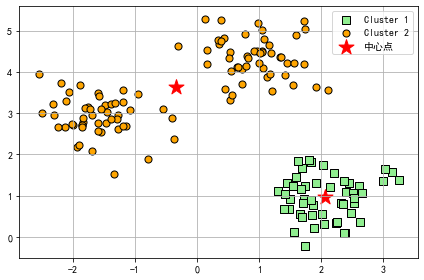

In [49]:
plt.scatter(X[y_km == 0, 0],
            X[y_km == 0, 1],
            s=50,
            c='lightgreen',
            edgecolor='black',
            marker='s',
            label='Cluster 1')
plt.scatter(X[y_km == 1, 0],
            X[y_km == 1, 1],
            s=50,
            c='orange',
            edgecolor='black',
            marker='o',
            label='Cluster 2')

plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
            s=250, marker='*', c='red', label='中心点')
plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('images/11_05.png', dpi=300)
plt.show()

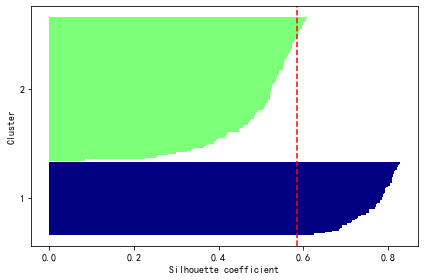

In [50]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
#plt.savefig('images/11_06.png', dpi=300)
plt.show()

<br>
<br>

# 使用层次树进行聚类

## 自下而上的层次聚类

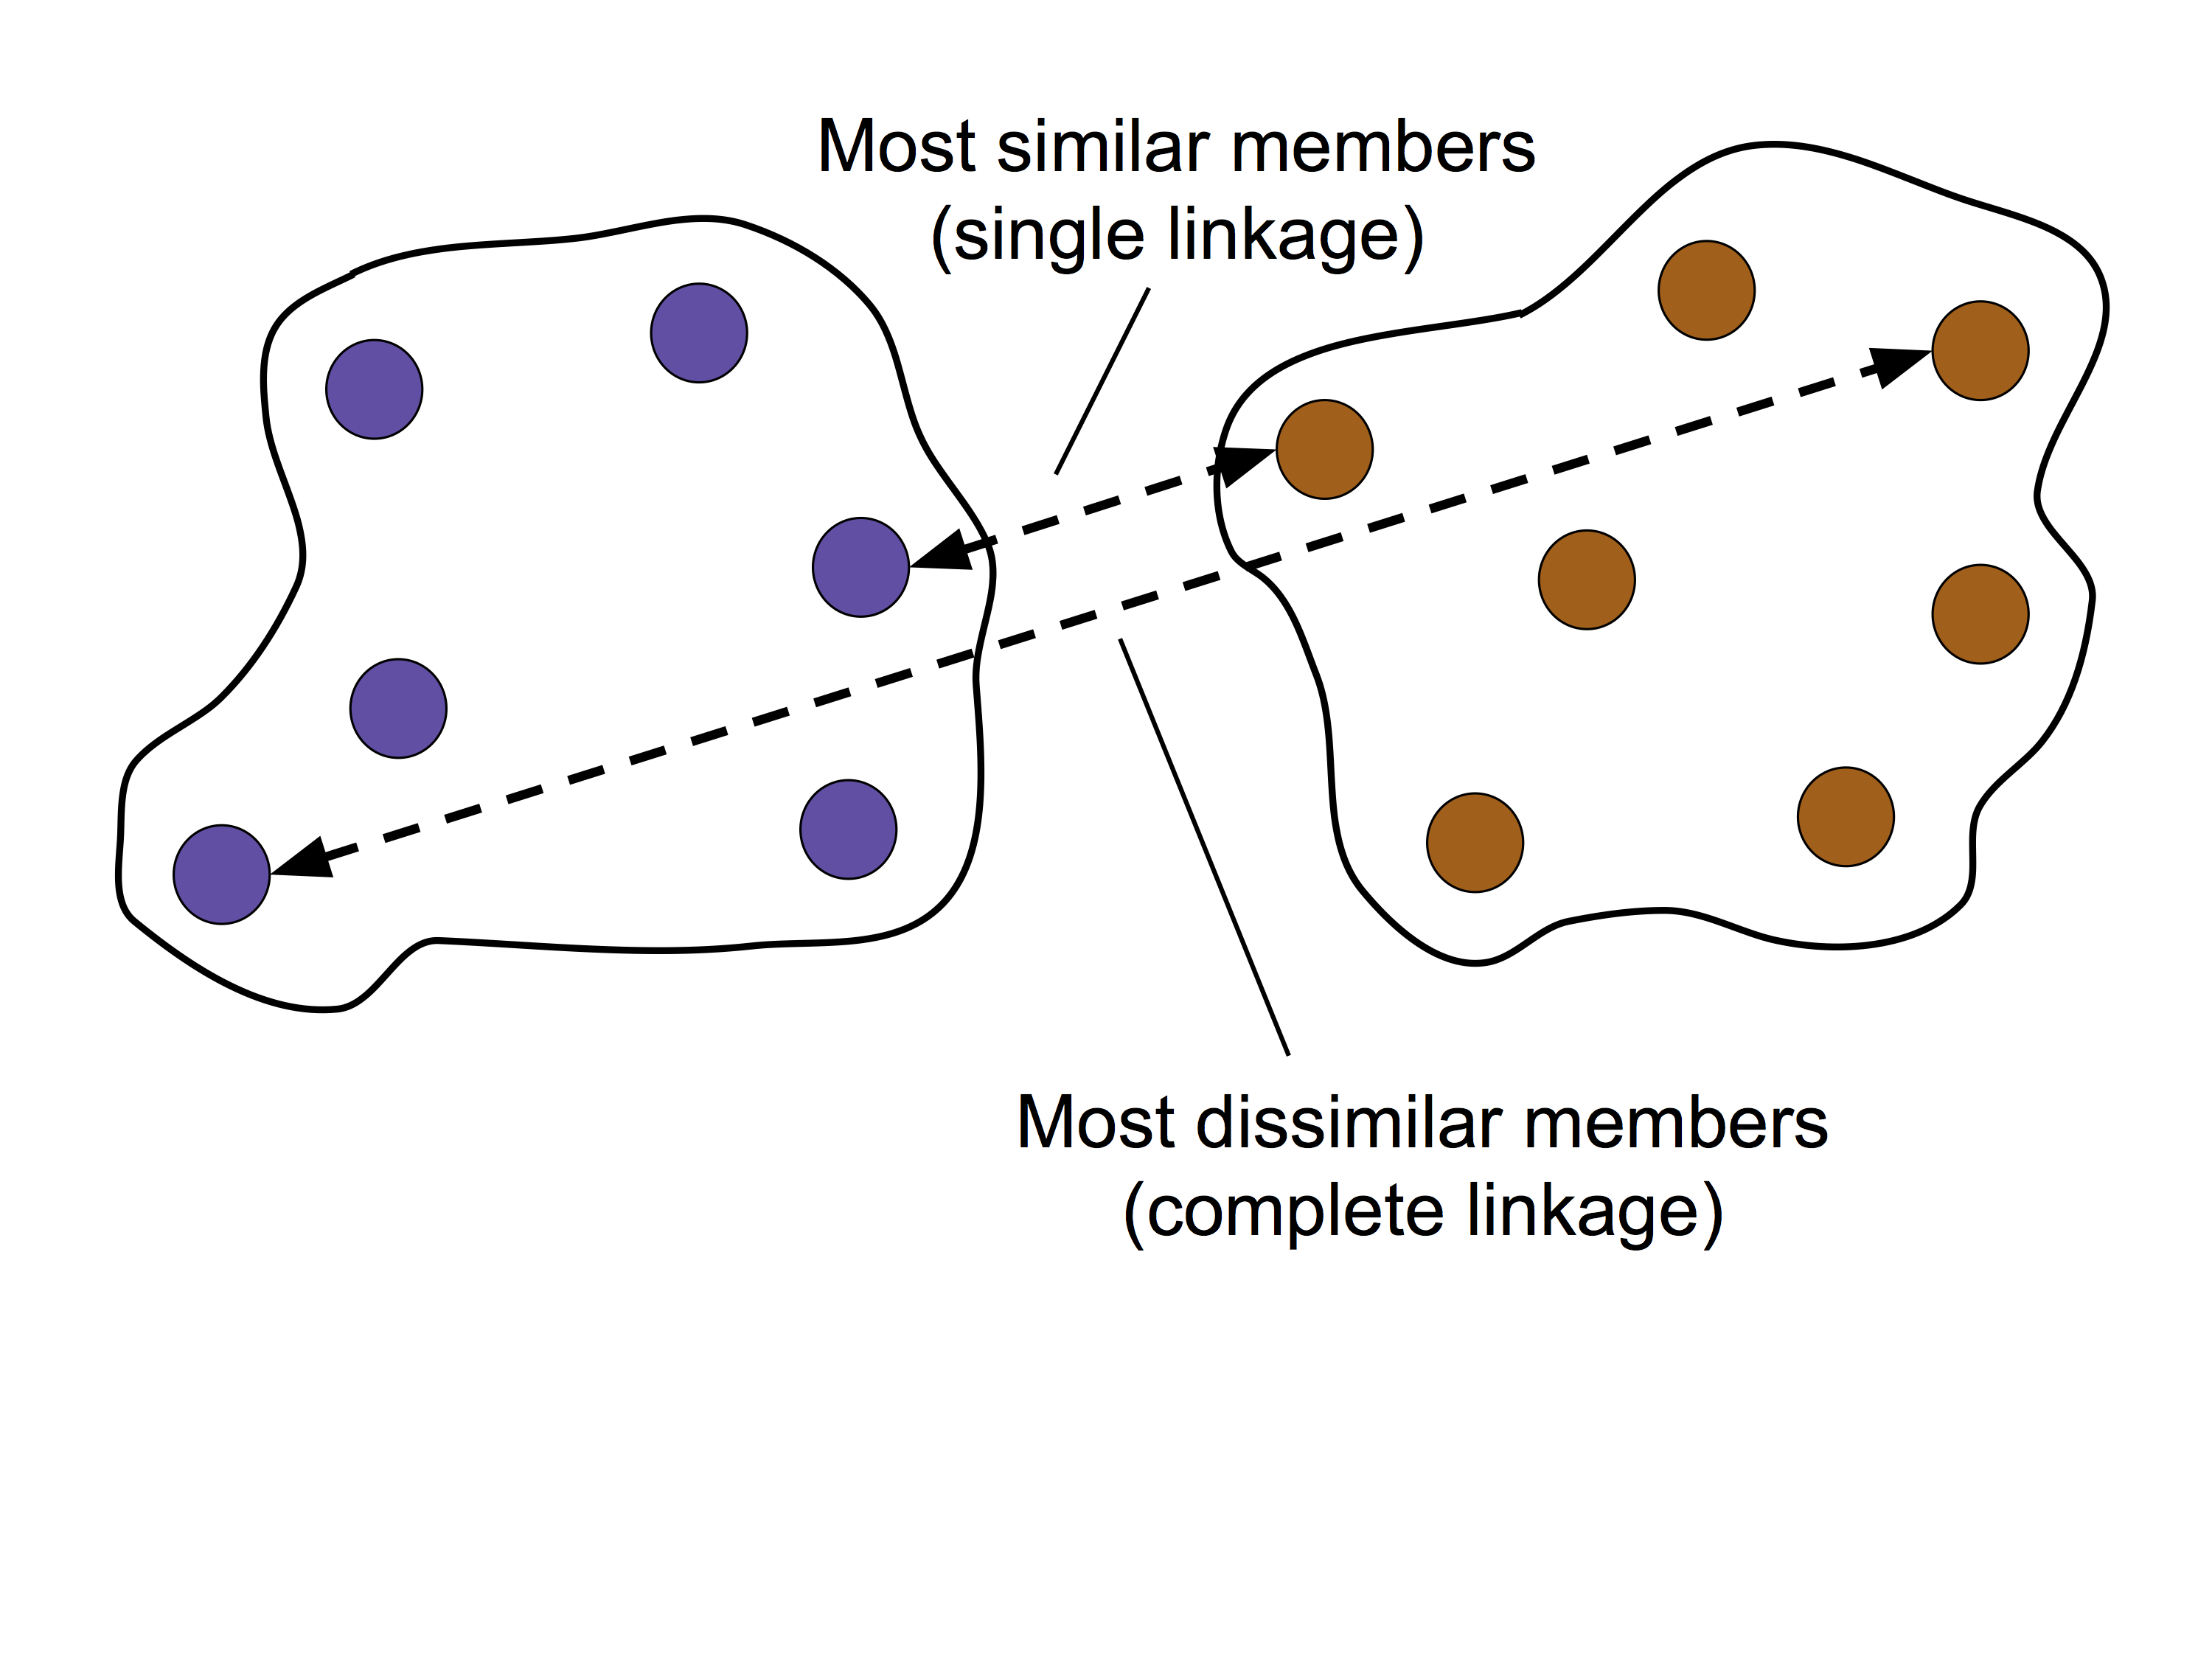

In [54]:
Image(filename='./images/linkage.png', width=400) 

# 根据电网负荷对用电时段进行层次聚类

## 读取数据

In [57]:
dfloading = pd.read_csv('data/ElectricityLoading.csv',index_col='时点') 

## 绘制负荷曲线

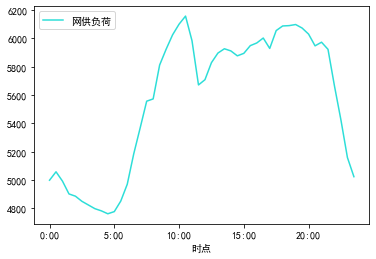

In [56]:
dfloading.plot(y='网供负荷',kind='line',color='#2dded8') 

<br>

## 根据距离矩阵进行层次聚类

- pdist(df, metric='euclidean') 计算两两的距离.
- squareform() Convert a vector-form distance vector to a square-form distance matrix, and vice-versa.把向量形式的距离向量转化为一个对称方阵。

In [58]:
loading_dist=pd.DataFrame(squareform(pdist(dfloading,metric='euclidean')))

In [59]:
row_clusters_loading=linkage(pdist(dfloading, metric='euclidean'), method='complete')

In [60]:
pd.DataFrame(row_clusters_loading,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1) 
                    for i in range(row_clusters_loading.shape[0])])

row label 1  row label 2  distance  no. of items in clust.
cluster 1          18.0         43.0       0.5                     2.0
cluster 2          31.0         41.0       1.4                     2.0
cluster 3           5.0         11.0       1.9                     2.0
cluster 4          26.0         30.0       2.0                     2.0
cluster 5          27.0         34.0       2.3                     2.0
cluster 6          36.0         37.0       2.4                     2.0
cluster 7          20.0         38.0       2.5                     2.0
cluster 8          19.0         40.0       5.2                     2.0
cluster 9           8.0         10.0       5.3                     2.0
cluster 10         32.0         42.0       5.4                     2.0
cluster 11         48.0         52.0       6.4                     4.0
cluster 12          0.0          2.0       6.7                     2.0
cluster 13         23.0         44.0       7.8                     2.0
cluster 14         53.0         54.0      12.6                     4.0
cluster 15         22.0         57.0      15.6                     3.0
cluster 16         15.0         16.0      15.9                     2.0
cluster 17          3.0          4.0      16.0                     2.0
cluster 18         17.0         25.0      16.7                     2.0
cluster 19         28.0         51.0      17.2                     3.0
cluster 20         35.0         39.0      17.9                     2.0
cluster 21          9.0         56.0      20.6                     3.0
cluster 22         13.0         46.0      25.8                     2.0
cluster 23          6.0          7.0      25.9                     2.0
cluster 24         49.0         58.0      26.1                     6.0
cluster 25         33.0         55.0      27.7                     3.0
cluster 26         12.0         59.0      28.5                     3.0
cluster 27          1.0         47.0      34.5                     2.0
cluster 28         29.0         66.0      34.7                     4.0
cluster 29         24.0         60.0      44.7                     3.0
cluster 30         61.0         67.0      45.1                     6.0
cluster 31         50.0         64.0      52.1                     4.0
cluster 32         14.0         45.0      54.0                     2.0
cluster 33         62.0         71.0      60.5                     9.0
cluster 34         68.0         70.0      61.9                     5.0
cluster 35         73.0         74.0      87.8                     5.0
cluster 36         72.0         77.0      97.7                     9.0
cluster 37         65.0         75.0      99.6                     6.0
cluster 38         78.0         81.0     139.9                     9.0
cluster 39         63.0         76.0     151.4                     5.0
cluster 40         21.0         83.0     154.6                    10.0
cluster 41         80.0         84.0     171.2                    15.0
cluster 42         69.0         82.0     214.0                     7.0
cluster 43         79.0         86.0     338.8                     7.0
cluster 44         87.0         88.0     345.0                    25.0
cluster 45         85.0         89.0     422.1                    16.0
cluster 46         90.0         91.0     787.1                    32.0
cluster 47         92.0         93.0    1393.4                    48.0

In [61]:
#或者采用以下形式
row_clusters_loading = linkage(dfloading.values, method='complete', metric='euclidean')
pd.DataFrame(row_clusters_loading,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'], 
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters_loading.shape[0])])

row label 1  row label 2  distance  no. of items in clust.
cluster 1          18.0         43.0       0.5                     2.0
cluster 2          31.0         41.0       1.4                     2.0
cluster 3           5.0         11.0       1.9                     2.0
cluster 4          26.0         30.0       2.0                     2.0
cluster 5          27.0         34.0       2.3                     2.0
cluster 6          36.0         37.0       2.4                     2.0
cluster 7          20.0         38.0       2.5                     2.0
cluster 8          19.0         40.0       5.2                     2.0
cluster 9           8.0         10.0       5.3                     2.0
cluster 10         32.0         42.0       5.4                     2.0
cluster 11         48.0         52.0       6.4                     4.0
cluster 12          0.0          2.0       6.7                     2.0
cluster 13         23.0         44.0       7.8                     2.0
cluster 14         53.0         54.0      12.6                     4.0
cluster 15         22.0         57.0      15.6                     3.0
cluster 16         15.0         16.0      15.9                     2.0
cluster 17          3.0          4.0      16.0                     2.0
cluster 18         17.0         25.0      16.7                     2.0
cluster 19         28.0         51.0      17.2                     3.0
cluster 20         35.0         39.0      17.9                     2.0
cluster 21          9.0         56.0      20.6                     3.0
cluster 22         13.0         46.0      25.8                     2.0
cluster 23          6.0          7.0      25.9                     2.0
cluster 24         49.0         58.0      26.1                     6.0
cluster 25         33.0         55.0      27.7                     3.0
cluster 26         12.0         59.0      28.5                     3.0
cluster 27          1.0         47.0      34.5                     2.0
cluster 28         29.0         66.0      34.7                     4.0
cluster 29         24.0         60.0      44.7                     3.0
cluster 30         61.0         67.0      45.1                     6.0
cluster 31         50.0         64.0      52.1                     4.0
cluster 32         14.0         45.0      54.0                     2.0
cluster 33         62.0         71.0      60.5                     9.0
cluster 34         68.0         70.0      61.9                     5.0
cluster 35         73.0         74.0      87.8                     5.0
cluster 36         72.0         77.0      97.7                     9.0
cluster 37         65.0         75.0      99.6                     6.0
cluster 38         78.0         81.0     139.9                     9.0
cluster 39         63.0         76.0     151.4                     5.0
cluster 40         21.0         83.0     154.6                    10.0
cluster 41         80.0         84.0     171.2                    15.0
cluster 42         69.0         82.0     214.0                     7.0
cluster 43         79.0         86.0     338.8                     7.0
cluster 44         87.0         88.0     345.0                    25.0
cluster 45         85.0         89.0     422.1                    16.0
cluster 46         90.0         91.0     787.1                    32.0
cluster 47         92.0         93.0    1393.4                    48.0

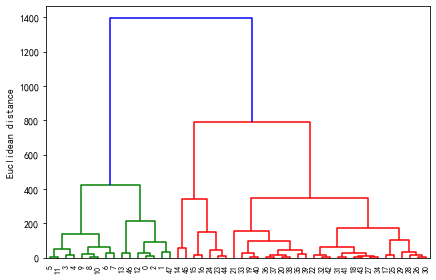

In [62]:
# make dendrogram black (part 1/2)
from scipy.cluster.hierarchy import set_link_color_palette
set_link_color_palette(['green','red','yellow'])

row_dendr = dendrogram(row_clusters_loading, orientation='top' #可以用left生成横向层级树图
                       ,leaf_font_size=8
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
#plt.savefig('images/11_11.png', dpi=300, 
#            bbox_inches='tight')
plt.show()

<br>

## 通过scikit-learn进行凝聚聚类

In [63]:

ac = AgglomerativeClustering(n_clusters=3, 
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [1 2 2 2 1 2 2 1 0 2 1 0 0 2 2 0 0 1 0 1 2 1 2 2 0 1 1 2 0 1 0 0 0 0 2 1 1
 1 2 2 0 0 2 1 1 1 0 2 0 2 1 2 2 1 1 0 2 1 0 2 0 0 0 0 2 0 2 1 2 2 2 1 1 2
 1 2 2 0 0 2 1 1 2 2 1 1 1 0 0 1 1 2 1 2 1 2 0 0 1 1 1 1 0 1 1 2 0 2 2 2 0
 2 1 0 2 0 2 2 0 0 2 1 2 2 1 1 0 1 0 0 0 0 1 0 0 0 2 0 1 0 2 2 1 1 0 0 0 0
 1 1]


<br>
<br>

# 通过DBSCAN划分高密度区域

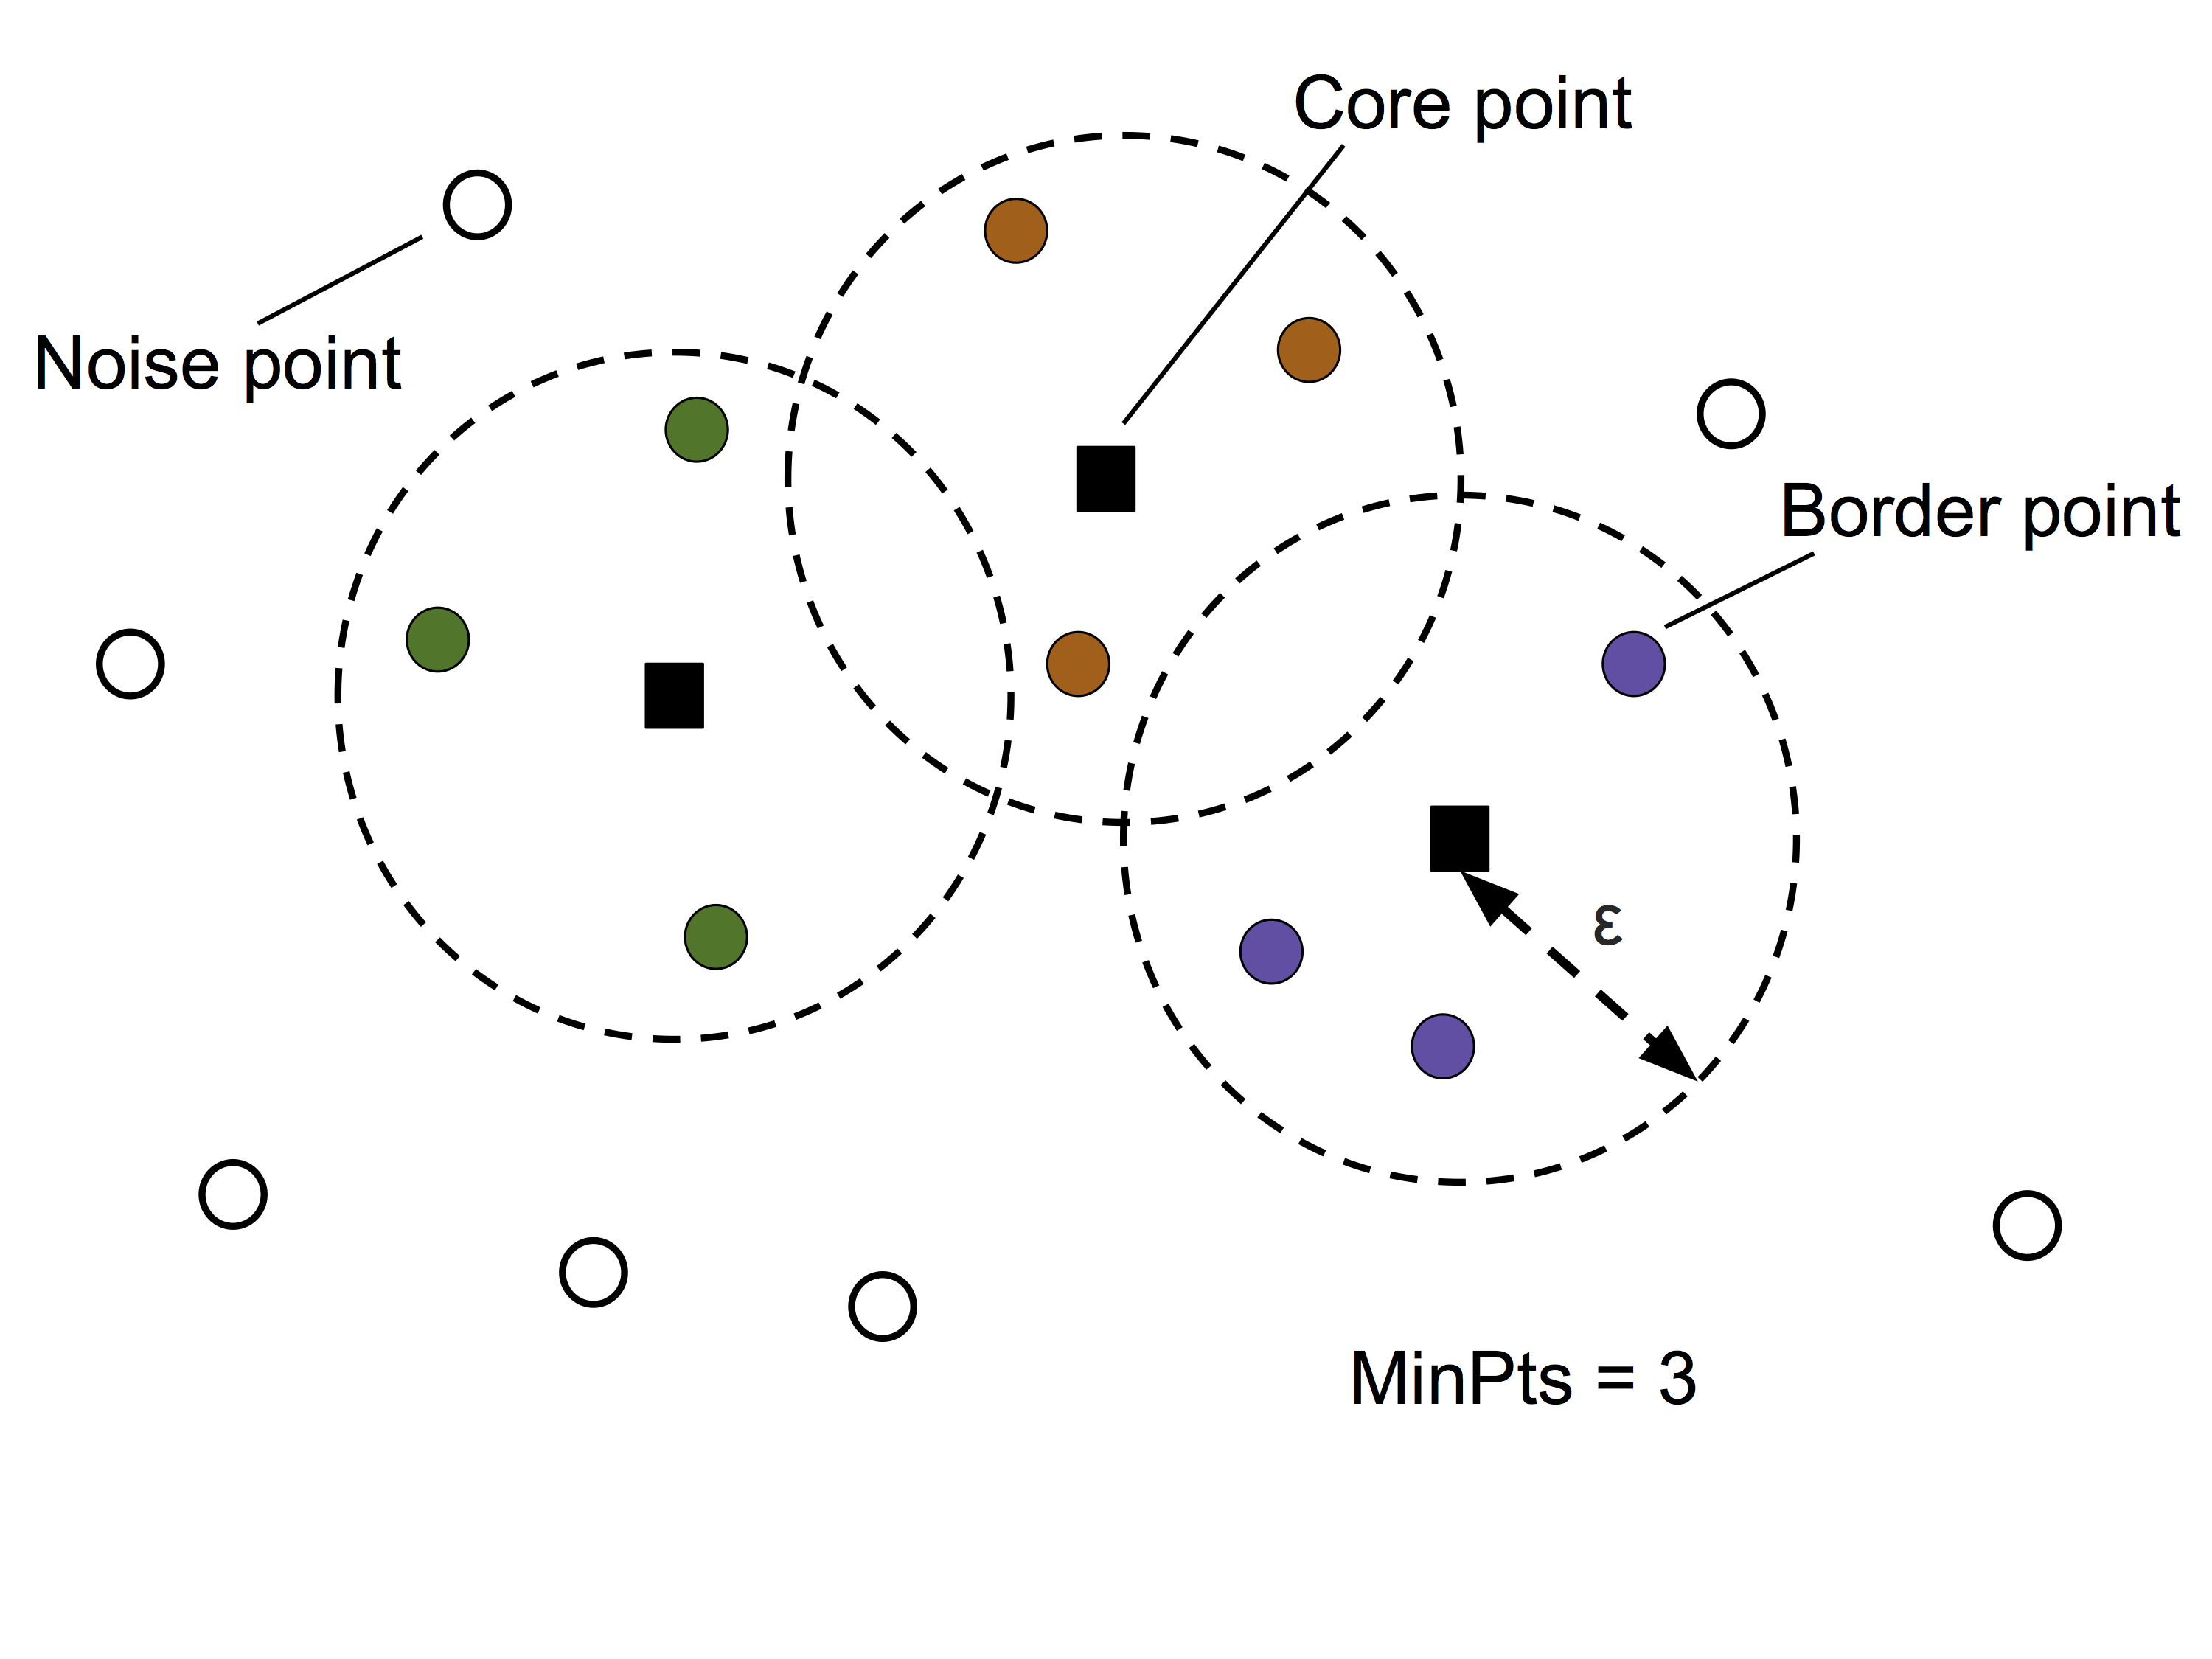

In [64]:
Image(filename='images/dbscan.png', width=500) 

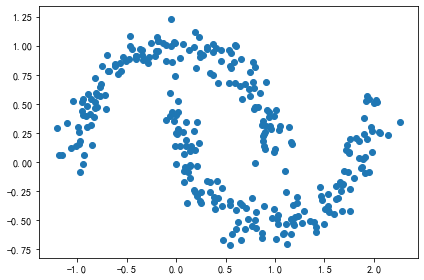

In [65]:
X, y = make_moons(n_samples=300, noise=0.1, random_state=0)
plt.scatter(X[:, 0], X[:, 1])
plt.tight_layout()
#plt.savefig('images/11_14.png', dpi=300)
plt.show()

K-means and hierarchical clustering:

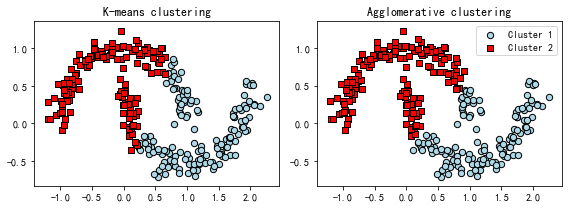

In [66]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1],
            edgecolor='black',
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1],
            edgecolor='black',
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')

ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='complete')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue',
            edgecolor='black',
            marker='o', s=40, label='Cluster 1')
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red',
            edgecolor='black',
            marker='s', s=40, label='Cluster 2')
ax2.set_title('Agglomerative clustering')

plt.legend()
plt.tight_layout()
#plt.savefig('images/11_15.png', dpi=300)
plt.show()

## 基于密度的聚类

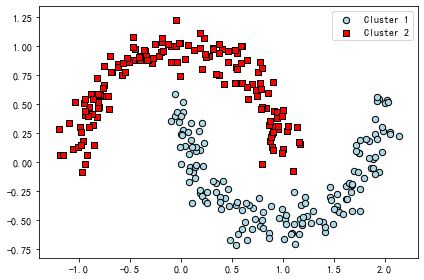

In [67]:
db = DBSCAN(eps=0.2, min_samples=8, metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black', 
            label='Cluster 1')
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black', 
            label='Cluster 2')
plt.legend()
plt.tight_layout()
#plt.savefig('images/11_16.png', dpi=300)
plt.show()

<br>
<br>

# 聚类分析在客户细分中的应用

In [68]:
CustomerData=pd.read_csv('data/RFM_Classify.csv')

CustomerData.head(3).T

0              1            2
CUSTCODE         00000000001    00000000002  00000000003
CUSTNAME            华普超市有限公司  北京恒昌吉商贸有限责任公司  北京丰文轩商贸有限公司
DT_Rf              2007/12/8      2007/12/3    2007/12/1
DT_Rq1             2007/12/8     2007/12/19   2007/12/12
DT_Rq2            2007/12/16     2007/12/26   2007/12/26
DT_Rq3            2007/12/16      2008/1/11     2008/1/6
DT_Rr             2007/12/16      2008/1/21    2008/1/21
Rf                       203            208          210
Rq1                      203            192          199
Rq2                      195            185          185
Rq3                      195            170          175
Recency                  195            160          160
Frequency                 15            656          585
MIN_FREQ                  15            278          240
AVG_FREQ                  15            328        292.5
MAX_FREQ                  15            378          345
Monetary             21523.4         723070  2.58428e+06
MIN_MNY_MONTHLY      21523.4         341439  1.13084e+06
AVG_MNY_MONTHLY      21523.4         361535  1.29214e+06
MAX_MNY_MONTHLY      21523.4         381631  1.45344e+06
MIN_MNY              6864.96         396.91       374.77
Q1_MNY               8813.33        16753.7      24612.6
Q2_MNY               10761.7        28886.7      48881.6
Q3_MNY               12710.1        35462.4      68957.1
MAX_MNY              14658.5        91571.7       191496
Factor1           -0.0833012      -0.604604    -0.540515
Factor2            -0.950314        2.94676      1.98489
Factor3           -0.0808476       0.527095      4.10517
RFM_CLUSTER                8              1            3
RFM_DISTANCE         66323.5        79654.5       659550
FACTOR_CLUSTER             4              3            7
FACTOR_DISTANCE      0.62646        1.35467      1.88083
CATEGORY                   0            111           11
RFM_CATEGORY             100             11           11
LOSABLE                 一般客户          易流失客户        重要新客户

In [69]:
rfm_cols=["Recency","Frequency","Monetary"]
factor_cols=["Factor1","Factor2","Factor3"]

rfmData=CustomerData[rfm_cols]
factorData=CustomerData[factor_cols]

rfmData

Recency  Frequency    Monetary
0         195         15    21523.41
1         160        656   723070.25
2         160        585  2584281.95
3         167         72    59553.05
4         160        322  1077343.89
...       ...        ...         ...
5350      181          5      796.05
5351      163         23   288235.18
5352      190          4   258830.32
5353      151         50  1300089.60
5354      180          5    56786.67

[5355 rows x 3 columns]

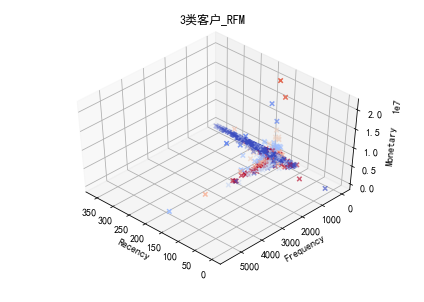

In [70]:
est_rfm = KMeans(n_clusters=8)
est_rfm.fit(rfmData)
labels_rfm=est_rfm.labels_
fig = plt.figure('RFM聚类分析')
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(rfmData.iloc[:, 0], rfmData.iloc[:, 1], rfmData.iloc[:, 2],c=labels_rfm.astype(np.float),s=20,marker='x',cmap='coolwarm')

ax.set_xlabel(rfm_cols[0])
ax.set_ylabel(rfm_cols[1])
ax.set_zlabel(rfm_cols[2])
ax.set_title("3类客户_RFM")
ax.dist = 12
plt.show() 

In [71]:
factorData

Factor1   Factor2   Factor3
0    -0.083301 -0.950314 -0.080848
1    -0.604604  2.946764  0.527095
2    -0.540515  1.984889  4.105172
3    -0.382294 -0.404900 -0.198605
4    -0.699839  0.911472  1.463128
...        ...       ...       ...
5350  0.095660 -0.962888 -0.162319
5351 -0.990445 -0.750649  0.608385
5352 -0.120499 -1.162972  0.645861
5353 -0.869783 -0.682763  1.611973
5354 -0.465795 -0.913083 -0.115537

[5355 rows x 3 columns]

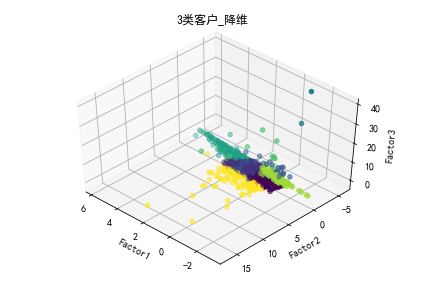

In [72]:
est_factor = KMeans(n_clusters=8)
est_factor.fit(factorData)
labels_factor=est_factor.labels_
fig = plt.figure('聚类分析')
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax.scatter(factorData.iloc[:, 0], factorData.iloc[:, 1], factorData.iloc[:, 2],c=labels_factor.astype(np.float))
ax.set_xlabel(factor_cols[0])
ax.set_ylabel(factor_cols[1])
ax.set_zlabel(factor_cols[2])
ax.set_title("3类客户_降维")
ax.dist = 12
plt.show()
